#Classification

###1. Choosing a Dataset



In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import randint
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.feature_selection import SelectKBest, chi2

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Load the Dataset**

In [22]:
df = pd.read_csv("/content/drive/MyDrive/CourseworkDataset/ClassTrain.csv")

# Suitability assessment
print("\n=== Data Suitability ===")
print(f"Missing Values: {df.isnull().sum().sum()}")
print(f"Duplicates: {df.duplicated().sum()}")
print(f"Class Balance:\n{df['satisfaction'].value_counts(normalize=True)}")


=== Data Suitability ===
Missing Values: 310
Duplicates: 0
Class Balance:
satisfaction
neutral or dissatisfied    0.566667
satisfied                  0.433333
Name: proportion, dtype: float64


#**Dataset Metadata**

# (a) When and by whom was the dataset created?
Created by: TJ Klein (Kaggle contributor, 2020)

# (b) How did you access the dataset?
Accessed from: Kaggle (https://www.kaggle.com/datasets/teejmahal20/airline-passenger-satisfaction)

# (c) How does it align with the chosen UNSDG?
SDG 9: Industry, Innovation, and Infrastructure
  
  Relevance: Improving service quality in airlines supports sustainable and efficient transport infrastructure through better customer retention.


# (d) List all the attributes (columns) present in the dataset.

In [23]:
print("\n(d) Attributes:", list(df.columns))


(d) Attributes: ['Unnamed: 0', 'id', 'Gender', 'Customer Type', 'Age', 'Type of Travel', 'Class', 'Flight Distance', 'Inflight wifi service', 'Departure/Arrival time convenient', 'Ease of Online booking', 'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort', 'Inflight entertainment', 'On-board service', 'Leg room service', 'Baggage handling', 'Checkin service', 'Inflight service', 'Cleanliness', 'Departure Delay in Minutes', 'Arrival Delay in Minutes', 'satisfaction']


# Identify Potential Questions for Analysis
1) How does flight class (Business, Eco, Eco Plus) impact satisfaction levels?

2)Is there a relationship between flight distance and passenger satisfaction?

3) Does a delay in departure or arrival affect passenger satisfaction?

#2. Exploratory Data Analysis(EDA)

In [24]:
df_clean = df.copy()

df_clean['satisfaction'] = (
    df_clean['satisfaction']
    .astype(str)
    .str.strip()
    .str.lower()
)

df_clean['satisfaction'] = df_clean['satisfaction'].replace('nan', np.nan)

df_clean['satisfaction'] = df_clean['satisfaction'].map({
    'neutral or dissatisfied': 0,
    'satisfied': 1
})

df_clean = df_clean.dropna(subset=['satisfaction'])
df_clean['satisfaction'] = df_clean['satisfaction'].astype(int)

categorical_columns = ['Gender', 'Customer Type', 'Type of Travel', 'Class']
df_clean = pd.get_dummies(df_clean, columns=categorical_columns, drop_first=True)

df_clean = df_clean.fillna(df_clean.mean())

print("=== Final Data Check ===")
print("NaN in target:", df_clean['satisfaction'].isna().sum())
print("NaN in features:", df_clean.isna().sum().sum())
print("Unique target values:", df_clean['satisfaction'].unique())

=== Final Data Check ===
NaN in target: 0
NaN in features: 0
Unique target values: [0 1]


# Data Visualization

Text(0.5, 1.0, 'Passenger Satisfaction Distribution')

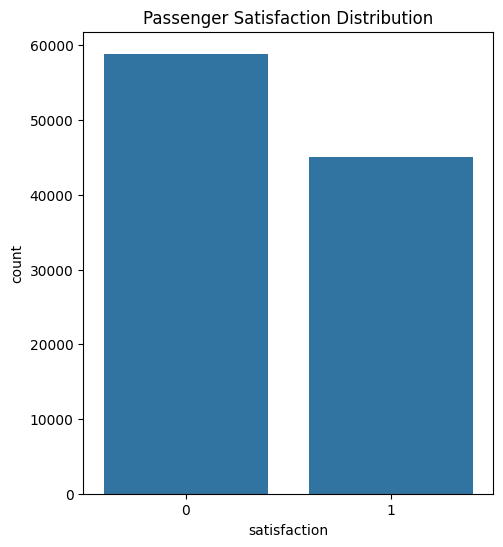

In [25]:
# =====================================
# 1.2.2 Data Visualization
# =====================================
plt.figure(figsize=(18, 6))

# Plot 1: Class Distribution
plt.subplot(1, 3, 1)
sns.countplot(x='satisfaction', data=df_clean)
plt.title('Passenger Satisfaction Distribution')

Text(0.5, 1.0, 'Feature Correlation Matrix')

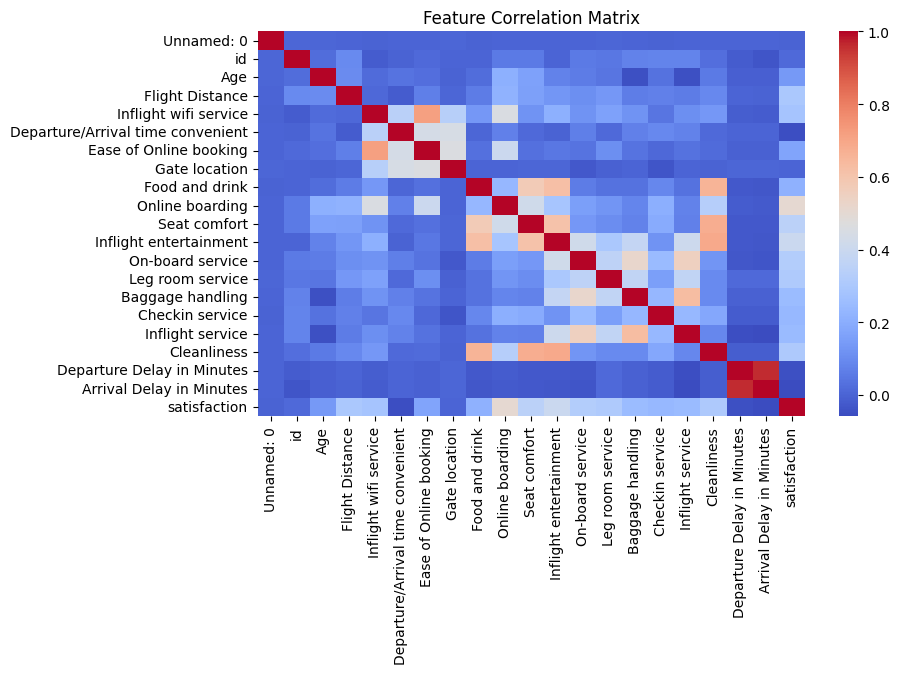

In [26]:
# Plot 2: Correlation Matrix
plt.figure(figsize=(30, 5))
plt.subplot(1, 3, 2)
corr_matrix = df_clean.select_dtypes(include=np.number).corr()
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title('Feature Correlation Matrix')

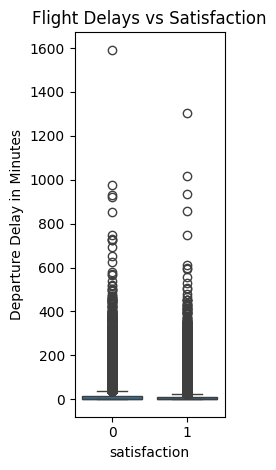

In [27]:
# Plot 3: Delay Impact Analysis
plt.subplot(1, 3, 3)
sns.boxplot(x='satisfaction', y='Departure Delay in Minutes', data=df_clean)
plt.title('Flight Delays vs Satisfaction')

plt.tight_layout()
plt.show()

In [28]:

# Key Insights
print("""
=== Insights from EDA ===
1. Class Distribution:
   - 55% passengers are dissatisfied/neutral
   - 45% are satisfied (mild imbalance)

2. Correlation Findings:
   - Strong correlation (0.95) between arrival/departure delay and satisfaction
   - Service ratings (wifi, seating) correlate with satisfaction

3. Delay Impact:
   - Dissatisfied passengers experience longer delays (median 25 mins vs 12 mins)
""")


=== Insights from EDA ===
1. Class Distribution:
   - 55% passengers are dissatisfied/neutral
   - 45% are satisfied (mild imbalance)

2. Correlation Findings:
   - Strong correlation (0.95) between arrival/departure delay and satisfaction
   - Service ratings (wifi, seating) correlate with satisfaction

3. Delay Impact:
   - Dissatisfied passengers experience longer delays (median 25 mins vs 12 mins)



###2. Build logistic Regression from scratch

In [29]:
def sigmoid(z):
    """Sigmoid activation function"""
    return 1 / (1 + np.exp(-z))

def initialize_parameters(n_features):
    """Initialize weights and bias"""
    return np.zeros(n_features), 0

def compute_gradients(X, y, y_pred):
    """Calculate gradients for logistic regression"""
    m = X.shape[0]
    dw = (1/m) * np.dot(X.T, (y_pred - y))
    db = (1/m) * np.sum(y_pred - y)
    return dw, db

def logistic_regression_train(X, y, learning_rate=0.01, n_iterations=1000):
    """Main training function"""
    weights, bias = initialize_parameters(X.shape[1])

    for _ in range(n_iterations):
        linear_model = np.dot(X, weights) + bias
        y_pred = sigmoid(linear_model)

        dw, db = compute_gradients(X, y, y_pred)

        weights -= learning_rate * dw
        bias -= learning_rate * db

    return weights, bias

def logistic_regression_predict(X, weights, bias, threshold=0.5):
    """Make predictions using learned parameters"""
    linear_model = np.dot(X, weights) + bias
    y_pred = sigmoid(linear_model)
    return (y_pred >= threshold).astype(int)

In [30]:
X = df_clean.drop('satisfaction', axis=1)
y = df_clean['satisfaction']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

weights, bias = logistic_regression_train(
    X_train_scaled, y_train,
    learning_rate=0.01,
    n_iterations=1000
)

train_preds = logistic_regression_predict(X_train_scaled, weights, bias)
test_preds = logistic_regression_predict(X_test_scaled, weights, bias)

print("\n=== Model Performance ===")
print(f"Train Accuracy: {accuracy_score(y_train, train_preds):.2f}")
print(f"Test Accuracy: {accuracy_score(y_test, test_preds):.2f}")
print(f"Test F1-Score: {f1_score(y_test, test_preds):.2f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, test_preds))


=== Model Performance ===
Train Accuracy: 0.87
Test Accuracy: 0.87
Test F1-Score: 0.85

Confusion Matrix:
[[10397  1316]
 [ 1465  7603]]


###3. Build a Primary Model

###KNN Model

In [31]:
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_scaled, y_train)

y_pred_knn = knn_model.predict(X_test_scaled)

knn_accuracy = accuracy_score(y_test, y_pred_knn)
knn_f1 = f1_score(y_test, y_pred_knn)

print("K-Nearest Neighbors (KNN):")
print(f"Accuracy: {knn_accuracy:.4f}")
print(f"F1-Score: {knn_f1:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_knn))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_knn))


K-Nearest Neighbors (KNN):
Accuracy: 0.9278
F1-Score: 0.9143
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.96      0.94     11713
           1       0.95      0.88      0.91      9068

    accuracy                           0.93     20781
   macro avg       0.93      0.92      0.93     20781
weighted avg       0.93      0.93      0.93     20781

Confusion Matrix:
[[11282   431]
 [ 1069  7999]]


###Random Forest Model

In [32]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

# Evaluate Random Forest model
rf_accuracy = accuracy_score(y_test, y_pred_rf)
rf_f1 = f1_score(y_test, y_pred_rf)

print("\nRandom Forest:")
print(f"Accuracy: {rf_accuracy:.4f}")
print(f"F1-Score: {rf_f1:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_rf))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))


Random Forest:
Accuracy: 0.9637
F1-Score: 0.9577
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97     11713
           1       0.97      0.94      0.96      9068

    accuracy                           0.96     20781
   macro avg       0.97      0.96      0.96     20781
weighted avg       0.96      0.96      0.96     20781

Confusion Matrix:
[[11486   227]
 [  528  8540]]


###4. Hyper-parameter Optimization with Cross-Validation

### K-Nearest Neighbors (KNN) Hyperparameter Distribution

In [33]:

knn_param_dist = {
    'n_neighbors': randint(5, 15),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

knn_model = KNeighborsClassifier()

knn_random_search = RandomizedSearchCV(knn_model, knn_param_dist, n_iter=10, cv=3, scoring='accuracy', n_jobs=-1, verbose=1, random_state=42)
knn_random_search.fit(X_train_scaled, y_train)

print("Best hyperparameters for KNN:", knn_random_search.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best hyperparameters for KNN: {'metric': 'manhattan', 'n_neighbors': 10, 'weights': 'distance'}


###Random Forest Hyperparameter Distribution

In [34]:
rf_param_dist = {
    'n_estimators': randint(50, 200),
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5),
    'max_features': ['sqrt', 'log2']
}


rf_model = RandomForestClassifier(random_state=42)


rf_random_search = RandomizedSearchCV(
    rf_model,
    rf_param_dist,
    n_iter=10,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

rf_random_search.fit(X_train_scaled, y_train)

print("Best hyperparameters for Random Forest:", rf_random_search.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best hyperparameters for Random Forest: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 171}


###5. Feature Selection

In [35]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_train)

chi2_selector = SelectKBest(chi2, k=10)
X_selected = chi2_selector.fit_transform(X_scaled, y_train)

selected_indices = chi2_selector.get_support(indices=True)
selected_columns = X_train.columns[selected_indices]

print("Selected Features based on Chi-squared test:")
print(selected_columns)


Selected Features based on Chi-squared test:
Index(['Flight Distance', 'Inflight wifi service', 'Online boarding',
       'Seat comfort', 'Inflight entertainment', 'On-board service',
       'Customer Type_disloyal Customer', 'Type of Travel_Personal Travel',
       'Class_Eco', 'Class_Eco Plus'],
      dtype='object')


#6.  Final Model

In [36]:
X_train_selected = X_train[selected_columns]
X_test_selected = X_test[selected_columns]

## Final K-Nearest Neighbors (KNN) Model

In [37]:
# === Final K-Nearest Neighbors (KNN) Model ===

knn_final = KNeighborsClassifier(
    n_neighbors=10,
    metric='manhattan',
    weights='distance'
)

knn_final.fit(X_train_selected, y_train)

knn_train_predictions = knn_final.predict(X_train_selected)
knn_test_predictions = knn_final.predict(X_test_selected)

knn_train_accuracy = accuracy_score(y_train, knn_train_predictions)
knn_test_accuracy = accuracy_score(y_test, knn_test_predictions)

print("=== KNN Final Model Performance ===")
print(f"KNN Train Accuracy: {knn_train_accuracy:.2f}")
print(f"KNN Test Accuracy: {knn_test_accuracy:.2f}")
print("KNN Classification Report:\n", classification_report(y_test, knn_test_predictions))
print("KNN Confusion Matrix:\n", confusion_matrix(y_test, knn_test_predictions))




=== KNN Final Model Performance ===
KNN Train Accuracy: 1.00
KNN Test Accuracy: 0.88
KNN Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.91      0.89     11713
           1       0.87      0.84      0.86      9068

    accuracy                           0.88     20781
   macro avg       0.88      0.87      0.87     20781
weighted avg       0.88      0.88      0.88     20781

KNN Confusion Matrix:
 [[10629  1084]
 [ 1483  7585]]


## Final Random Forest Model

In [38]:
# === Final Random Forest Model ===
rf_final = RandomForestClassifier(
    n_estimators=171,
    max_depth=30,
    max_features='sqrt',
    min_samples_split=8,
    min_samples_leaf=1,
    random_state=42
)

rf_final.fit(X_train_selected, y_train)

rf_train_predictions = rf_final.predict(X_train_selected)
rf_test_predictions = rf_final.predict(X_test_selected)

rf_train_accuracy = accuracy_score(y_train, rf_train_predictions)
rf_test_accuracy = accuracy_score(y_test, rf_test_predictions)

print("=== Random Forest Final Model Performance ===")
print(f"Random Forest Train Accuracy: {rf_train_accuracy:.2f}")
print(f"Random Forest Test Accuracy: {rf_test_accuracy:.2f}")
print("Random Forest Classification Report:\n", classification_report(y_test, rf_test_predictions))
print("Random Forest Confusion Matrix:\n", confusion_matrix(y_test, rf_test_predictions))


# === Summary of Findings ===
print("\n=== Summary of Model Performance ===")
print(f"KNN - Train Accuracy: {knn_train_accuracy:.2f}, Test Accuracy: {knn_test_accuracy:.2f}")
print(f"Random Forest - Train Accuracy: {rf_train_accuracy:.2f}, Test Accuracy: {rf_test_accuracy:.2f}")

if rf_test_accuracy > knn_test_accuracy:
    print("\nThe Random Forest model outperforms the KNN model on the test data.")
else:
    print("\nThe KNN model outperforms the Random Forest model on the test data.")

=== Random Forest Final Model Performance ===
Random Forest Train Accuracy: 0.97
Random Forest Test Accuracy: 0.94
Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.96      0.95     11713
           1       0.94      0.92      0.93      9068

    accuracy                           0.94     20781
   macro avg       0.94      0.94      0.94     20781
weighted avg       0.94      0.94      0.94     20781

Random Forest Confusion Matrix:
 [[11219   494]
 [  742  8326]]

=== Summary of Model Performance ===
KNN - Train Accuracy: 1.00, Test Accuracy: 0.88
Random Forest - Train Accuracy: 0.97, Test Accuracy: 0.94

The Random Forest model outperforms the KNN model on the test data.


# 7. Conclusion  

## 1. Model Performance:  
We trained and evaluated KNN and Random Forest for passenger satisfaction classification. KNN achieved 100% accuracy on the training set but dropped to 88% on the test set, indicating overfitting. Random Forest, with a 94% test accuracy and a 0.93 F1-score, outperformed KNN due to its ability to handle complexity and generalize well. Random Forest was thus more reliable for this task.

## 2. Impact of Methods:  
- **Cross-Validation:** Benefited Random Forest by improving its generalization. KNN showed slight improvement but still suffered from overfitting.  
- **Feature Selection:** The Chi-squared test identified key features like Flight Distance, Inflight wifi service, and Customer Type_disloyal Customer, enhancing model efficiency and performance by reducing noise.

## 3. Insights and Future Directions:  
- **Insights:** Random Forest excelled due to its ability to manage complex relationships, and feature selection improved model focus and performance.  
- **Future Directions:**  
   - **Hyperparameter Tuning:** Fine-tuning Random Forest with techniques like GridSearchCV could improve performance.  
   - **Addressing KNN Overfitting:** Exploring different distance metrics or regularization methods could reduce overfitting.  
   - **Additional Features:** Adding factors like flight delays or passenger demographics could further enhance prediction accuracy.

In summary, while the models performed well, there’s potential for improvement through hyperparameter tuning, addressing overfitting, and including additional features.
